# CIFAR -10 accuracy test

# Library

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader
import numpy as np

from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: gpu") if torch.cuda.is_available() else print("device: cpu")

device: gpu


# Hyper parameter setting

In [0]:
learning_rate = 1e-4
epochs = 50
display_step = 10
batch_size = 32

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2)

# Load data & Pre-process data

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
len(train_data):  50000
len(test_data):  10000
data tensor([[[0.2314, 0.2431, 0.2471],
         [0.1686, 0.1804, 0.1765],
         [0.1961, 0.1882, 0.1686],
         ...,
         [0.6196, 0.5176, 0.4235],
         [0.5961, 0.4902, 0.4000],
         [0.5804, 0.4863, 0.4039]],

        [[0.0627, 0.0784, 0.0784],
         [0.0000, 0.0000, 0.0000],
         [0.0706, 0.0314, 0.0000],
         ...,
         [0.4824, 0.3451, 0.2157],
         [0.4667, 0.3255, 0.1961],
         [0.4784, 0.3412, 0.2235]],

        [[0.0980, 0.0941, 0.0824],
         [0.0627, 0.0275, 0.0000],
         [0.1922, 0.1059, 0.0314],
         ...,
         [0.4627, 0.3294, 0.1961],
         [0.4706, 0.3294, 0.1961],
         [0.4275, 0.2863, 0.1647]],

        ...,

        [[0.8157, 0.6667, 0.3765],
         [0.7882, 0.6000, 0.1333],
         [0.7765, 0.6314, 0.1020],
         ...,
         [0.6275, 0.5216, 0.2745],
         [0.2196, 0.12

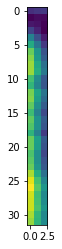

data shape: torch.Size([32, 3, 32, 32])
label: tensor([2, 9, 4, 5, 6, 6, 4, 6, 0, 7, 3, 2, 4, 1, 5, 2, 9, 0, 2, 9, 9, 1, 2, 9,
        8, 1, 9, 3, 5, 6, 0, 0])


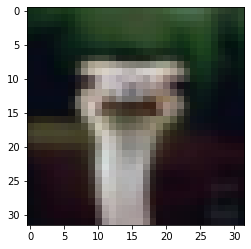

In [4]:
# load data
train_data = dataset.CIFAR10("./", train = True, transform = transforms.ToTensor(), target_transform = None, download = True)
test_data = dataset.CIFAR10("./", train = False, transform = transforms.ToTensor(), target_transform = None, download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
x_train = np.transpose(x_train, (1,2,0))
# 3 x 32 x 32에서 32 x 32 x 3으로 변환

print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers = 1, drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(np.transpose(example_data[0], (1,2,0)))
plt.show()

# Model & Optimization and Loss function

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() 
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 128, 5),
            nn.BatchNorm2d(128),
            activation,
            max_pool,
            nn.Dropout(0.5),
            
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            activation,
            max_pool,
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 100),
            nn.BatchNorm1d(100),
            activation,
            nn.Dropout(0.3),
            nn.Linear(100, 10)
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # [32, 256, 6, 6]
        flatten = extracted_feature.view(batch_size, -1) # [32, 256 * 6 * 6]
        result = self.classifier(flatten)
        return result
    

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
        
model = CNN()
model.apply(init_weights)
model.to(device)
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


# Train & Test

In [11]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 1.6080734729766846
10 epoch loss: 0.9838777780532837
20 epoch loss: 0.922745943069458
30 epoch loss: 0.5212856531143188
40 epoch loss: 0.31189560890197754


In [12]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("CIFAR10 test_accuracy : {}".format(correct/total))

CIFAR10 test_accuracy : 0.8027844429016113
